In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import itertools as it
import scipy.stats.qmc as ssq
from scipy.stats import chisquare
from seaborn import displot
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space.space import Real, Integer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

np.set_printoptions(threshold=100_000)
X = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\parameters.csv")
# X = X[['gamma_g', 't_peak', 'gamma_d', 'sd_antarctic',
#        'rho_greenland', 'rho_gmsl', 'temperature_0', 'ocean_heat_0', 'Q10',
#        'CO2_diffusivity', 'heat_diffusivity', 'rf_scale_aerosol',
#        'climate_sensitivity', 'thermal_alpha', 'greenland_a', 'greenland_b',
#        'greenland_alpha', 'greenland_beta', 'anto_alpha', 'antarctic_mu',
#        'antarctic_precip0', 'antarctic_runoff_height0', 'antarctic_lambda',
#        'antarctic_temp_threshold', 'lw_random_sample']].copy()
Y = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\gmslr.csv")
Y = Y.mean(axis=1).rename('output')
obj = X.join(Y, how='left')
obj.sort_values(by='t_peak',ascending=True, inplace=True)
# Rescaling the dataset
# min_max = MinMaxScaler()
# min_max.fit(obj.iloc[:,:-1],obj.iloc[:,-1])

# obj_scaled = min_max.transform(obj.iloc[:,:-1])
# obj_y = obj.iloc[:,-1].copy()


In [17]:
obj

,gamma_g,t_peak,gamma_d,sd_temp,sd_ocean_heat,sd_glaciers,sd_greenland,sd_antarctic,sd_gmsl,rho_temperature,...,antarctic_kappa,antarctic_flow0,antarctic_runoff_height0,antarctic_c,antarctic_bed_height0,antarctic_slope,antarctic_lambda,antarctic_temp_threshold,lw_random_sample,output
75300,0.006347,2030.0,0.063484,0.085504,1.531144,0.000034,0.000207,0.000130,0.001524,0.438387,...,0.037543,1.525722,1788.008184,102.503463,741.445846,0.000646,0.008453,-15.477981,0.000482,0.698388
10964,0.007240,2030.0,0.040575,0.085529,1.438011,0.000016,0.000282,0.000330,0.001650,0.435206,...,0.064268,1.227204,1483.309624,140.186655,778.177732,0.000704,0.009543,-15.788140,0.000020,0.331414
70160,0.002259,2030.0,0.144216,0.092857,3.723968,0.000323,0.000209,0.000514,0.001650,0.487182,...,0.033567,1.660323,1520.205881,88.304474,809.067960,0.000643,0.017545,-16.382468,0.000483,0.413392
55254,0.011053,2030.0,0.122078,0.079322,3.501653,0.000098,0.000281,0.000548,0.000294,0.587828,...,0.065723,1.606463,2000.054921,138.560673,740.928017,0.000657,0.022982,-16.102901,0.000169,0.425493
92866,0.011820,2030.0,0.107974,0.084704,0.286660,0.000283,0.000252,0.000342,0.001516,0.340300,...,0.080096,0.979125,972.389176,120.286640,814.950370,0.000725,0.006661,-15.362369,0.000193,0.352666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52429,0.013229,2167.0,0.093814,0.080127,1.034033,0.000253,0.000202,0.000538,0.000763,0.518355,...,0.069314,1.460019,1379.251183,117.385686,797.296496,0.000668,0.011739,-16.190533,0.000739,3.135588
26215,0.003130,2169.0,0.022636,0.079961,2.088501,0.000069,0.000217,0.000380,0.001736,0.665597,...,0.065737,1.516385,1673.690577,136.186139,787.740252,0.000562,0.012827,-16.224729,0.000183,2.118476
87383,0.004158,2171.0,0.120120,0.078078,0.375789,0.000049,0.000264,0.000451,0.002437,0.763427,...,0.080312,0.812621,1340.939748,76.307069,798.575153,0.000548,0.009879,-15.795974,0.000354,2.240000
43691,0.007347,2172.0,0.049480,0.072067,2.871035,0.000278,0.000222,0.000539,0.001515,0.628720,...,0.078433,1.567668,1431.133514,120.324753,811.646750,0.000652,0.014322,-15.887230,0.000333,2.066674


In [2]:
val = train_test_split(obj.iloc[:,:-1],obj.iloc[:,-1],shuffle=False, train_size=0.8, random_state=0)
# val = TimeSeriesSplit(n_splits=4, max_train_size=60_000)
#Darnell MSE8 n_estimators=199, max_depth=26, max_features=30, min_samples_leaf=2,n_jobs=10,
# Darnell MSE10:max_depth=36, max_features=33, n_estimators=300,
# max_depth=38, max_features=17,n_estimators=300
#==================================================================================================
RF = RandomForestRegressor(n_estimators=286, max_depth=74, max_features=41, n_jobs=20,random_state=0)

In [3]:
RF.fit(val[0], val[2])

RandomForestRegressor(max_depth=74, max_features=41, n_estimators=286,
                      n_jobs=20, random_state=0)

In [4]:
RF.feature_importances_

array([0.04060604, 0.29921388, 0.15734342, 0.0017413 , 0.00172197,
       0.00172372, 0.00187324, 0.00211575, 0.00186371, 0.0017838 ,
       0.00172738, 0.00170339, 0.00238001, 0.00176835, 0.00234434,
       0.00177969, 0.00176113, 0.00230559, 0.00219573, 0.00177501,
       0.00181758, 0.00181751, 0.00168073, 0.00171136, 0.00577174,
       0.00197302, 0.00231739, 0.0020005 , 0.02556755, 0.16669768,
       0.0022313 , 0.00327567, 0.00437348, 0.00227696, 0.00481456,
       0.00169603, 0.00173944, 0.00200783, 0.00168246, 0.00173006,
       0.00176532, 0.00611118, 0.00176719, 0.00259122, 0.00187844,
       0.00197663, 0.00211611, 0.00186064, 0.00169119, 0.00169849,
       0.08631243, 0.11998821, 0.00333264])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=150)

plt.plot(obj.t_peak, obj.output, color='blue', label='True')
plt.plot(obj.t_peak, RF.predict(obj.iloc[:,:-1]), color='firebrick', label='Predicted')
plt.title('Test Predictions vs. True Output')
plt.ylabel('Risk Estimate')
plt.xlabel(r'$\tau$ (year of peak emissions)')
plt.legend()

In [ ]:
print(f'Train MSE={np.mean(np.square(val[2].to_numpy()-RF.predict(val[0].to_numpy())))}')
print(f'Test MSE={np.mean(np.square(val[3].to_numpy()-RF.predict(val[1].to_numpy())))}')
# print(f'Importances:\n{RF.feature_importances_}')

In [10]:
parameter_space = dict()
parameter_space['n_estimators'] = Integer(30,300)
parameter_space['min_samples_split'] = Integer(2,5, prior='uniform')
parameter_space['min_samples_leaf'] = Integer(1,5)
parameter_space['max_features'] = Integer(10,53)
parameter_space['max_depth'] = Integer(10,80)
# parameter_space['ccp_alpha'] = Real(1e-4, 5e-4)

In [ ]:
bae = BayesSearchCV(estimator=RF,search_spaces=parameter_space,verbose=2, n_iter=100, scoring='neg_mean_squared_error', n_points=6, cv=val, n_jobs=24, random_state=0)
bae.fit(obj.iloc[:,:-1], obj.iloc[:,-1])
res = pd.DataFrame(bae.cv_results_)
res.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Hyperparameter_Tuning\Darnell_HT_MSE_11.xlsx")
res.to_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Hyperparameter_Tuning\Darnell_HT_MSE_11.csv")
print(f'Best Parameters:{bae.best_params_} with MSE: {bae.best_score_}')

In [5]:
rng = np.random.default_rng(seed=0)
def bootstrapp(y_true,y_pred,n_boots):
    rows = len(y_true)
    error = (y_true - y_pred).to_numpy()
    S_CI = np.zeros((n_boots,))
    for i in range(n_boots):
        indx = rng.choice(rows, size=rows, replace=True)
        S_CI[i] = np.mean(np.square(error[indx]))
    return S_CI

In [6]:
def pvi1(data: pd.DataFrame, y_true: np.ndarray[float], f: callable,*, n_boots: int, alpha: float, column_set: dict) -> tuple[pd.DataFrame]:
    rows, columns = data.shape
    npv_columns = column_set
    V_y = np.var(y_true, ddof=1)
    u = dict()
    CI = dict()
    # rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    rolled_data = np.roll(data.copy(),rows//2, axis=0)
    # for cat,col in npv_columns.items():
    for col in npv_columns:
        d = rolled_data.copy()
        d[:, col] = data[:,col]
        y_pred = f(d)
        u[col] = 1-np.mean(np.square(y_true - y_pred))/(2*V_y)
    #     S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
    #     p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
    #     CI[col] = [p0,p1,p1-p0]
    # CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    # CI.index.name = 'Interactions'
    # CI.columns.name = 'Confidence Interval Difference'
    # SI = pd.DataFrame(u.values(), index=u.keys(), columns=['$P_{i}$'])
    return u

In [22]:
def mod_pvi1(data: pd.DataFrame, y_true: np.ndarray[float], f: callable,*, n_boots: int, alpha: float, column_set: dict) -> tuple[pd.DataFrame]:
    rows, columns = data.shape
    npv_columns = column_set
    V_y = np.var(y_true, ddof=1)
    u = dict()
    CI = dict()
    rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    # rolled_data = np.roll(data.copy(), rows//2, axis=0)
    for cat, col in npv_columns.items():
        d = rolled_data.copy()
        d[col] = data[col].to_numpy()
        y_pred = f(d)
        u[cat] = 1-np.mean(np.square(y_true - y_pred))/(2*V_y)
        S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
        p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
        CI[cat] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'
    SI = pd.DataFrame(u.values(), index=u.keys(), columns=['$P_{i}$'])
    return u,CI

In [8]:
def pvi_t(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,n_boots: int, alpha: float, column_set: list[str]) -> np.ndarray[float]:
    '''
    ===Total-Order Permutation Variable Importances===

        data: your training dataset
        y_pred: your model output (specifically the prediction of your 'data' arg)
        f: in this case, simply RF.predict
    '''
    rows, columns = data.shape
    npv_columns = column_set
    u = np.zeros((columns,))
    V_y = np.var(y_true, ddof=1)
    CI = dict()
    for col in npv_columns:
        d = data.copy()
        d[:, col] = np.roll(data[:, col],rows//2, axis=0)
        y_pred = f(d)
        u[col] = np.mean(np.square(y_true - y_pred))/(2*V_y)
    #     S_CI = bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
    #     p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
    #     CI[col] = [p0,p1,p1-p0]
    # CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    # CI.index.name = 'Interactions'
    # CI.columns.name = 'Confidence Interval Difference'
    # S_t = pd.DataFrame(u.values(), index=u.keys(), columns=[r'$P_{\tau}$'])
    return u

In [9]:
def mod_pvi_t(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,n_boots: int, alpha: float, column_set: list[str]) -> np.ndarray[float]:
    '''
    ===Total-Order Permutation Variable Importances===

        data: your training dataset
        y_pred: your model output (specifically the prediction of your 'data' arg)
        f: in this case, simply RF.predict
    '''
    rows, columns = data.shape
    npv_columns = column_set
    u = dict()
    V_y = np.var(y_true,ddof=1 )
    CI = dict()
    for cat,col in npv_columns.items():
        d = data.copy()
        d[col] = np.roll(data[col],rows//2, axis=0)
        y_pred = f(d)
        u[cat] = np.mean(np.square(y_true - y_pred))/(2*V_y)
        S_CI = bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
        p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
        CI[cat] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'
    S_t = pd.DataFrame(u.values(), index=u.keys(), columns=[r'$P_{\tau}$'])
    return u, CI

In [10]:
def pvi2(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,S_I: np.ndarray[float] ,n_boots: int, alpha: float, columns_set: dict) -> tuple[np.ndarray[float], list]:
    '''
    ===Second-Order Permutation Variable Importances (Full Matrix)===

        data: your training dataset
        y_pred: your model output (specifically the y_true value)
        f: in this case, simply RF.predict

        S_I: First-Order Importances
        n_boots: number of bootstrap samples
        alpha: parameter for confidence interval [alpha, 1-alpha]
        S_CI: sampling distribution 
        CI: Confidence Intervals
    '''
    rows, columns = data.shape
    npv_columns = columns_set
    n = n_boots
    S = np.zeros((columns, columns))
    CI = dict()
    V_y = np.var(y_true, ddof=1)
    # rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    rolled_data = np.roll(data.copy(),rows//2, axis=0)
    for col1,col2 in it.combinations(npv_columns, r=2):
        d = rolled_data.copy()
        d[:,[col1, col2]] = data[:,[col1,col2]]
        y_pred = f(d)
        S_cat1 = S_I[col1]
        S_cat2 = S_I[col2]
        print(f'First-Order:\t{S_cat1, S_cat2}')
        # print(f'First Part:\t{np.mean(np.square(y_true - f(d)))/(2*V_y)}')
        # print(f'Second Part:\t{S_cat1}')
        # print(f'Third Part:\t{S_cat2}')
        S[col1, col2] = 1 - np.mean(np.square(y_true - y_pred))/(2*V_y) - S_cat1 - S_cat2
        print(f'Second-Order:\t{S[col1,col2]}')

    #     S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y) - S_cat1 - S_cat2
    #     p0,p1= np.quantile(S_CI, [alpha,1-alpha])
    #     CI[(col1, col2)] = [p0,p1,p1-p0]
    # CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    # CI.index.name = 'Interactions'
    # CI.columns.name = 'Confidence Interval Difference'

    # S = pd.DataFrame(S.values(), index=S.keys(), columns=[r'$P_{ik}$'])
    return S

In [11]:
def mod_pvi2(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,S_I: np.ndarray[float] ,n_boots: int, alpha: float, columns_set: dict) -> tuple[np.ndarray[float], list]:
    '''
    ===Second-Order Permutation Variable Importances (Full Matrix)===

        data: your training dataset
        y_pred: your model output (specifically the y_true value)
        f: in this case, simply RF.predict

        S_I: First-Order Importances
        n_boots: number of bootstrap samples
        alpha: parameter for confidence interval [alpha, 1-alpha]
        S_CI: sampling distribution 
        CI: Confidence Intervals
    '''
    rows, columns = data.shape
    npv_columns = columns_set
    n = n_boots
    S = dict()
    CI = dict()
    V_y = np.var(y_true, ddof=1)
    rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    # rolled_data = np.roll(data.copy(), rows//2, axis=0)
    for (cat1,col1),(cat2, col2) in it.combinations(npv_columns.items(), r=2):
        col = col1+col2
        d = rolled_data.copy()
        d[col] = data[col]
        y_pred = f(d)
        S_cat1 = S_I[cat1]
        S_cat2 = S_I[cat2]
        S[(cat1, cat2)] = 1 - np.mean(np.square(y_true - y_pred))/(2*V_y) - S_cat1 - S_cat2
        S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y) - S_cat1 - S_cat2 # Bootstrap Process
        p0,p1= np.quantile(S_CI, [alpha,1-alpha])
        CI[(cat1, cat2)] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'

    # S = pd.DataFrame(S.values(), index=S.keys(), columns=[r'$P_{ik}$'])
    return S, CI

In [12]:
Variables = ['sd_temp', 'sd_ocean_heat', 'sd_glaciers', 'sd_greenland','sd_antarctic',
              'sd_gmsl', 'rho_temperature','rho_ocean_heat', 
              'rho_glaciers', 'rho_greenland', 'rho_antarctic','rho_gmsl']
Climate = ['CO2_0', 'N2O_0', 'temperature_0','ocean_heat_0','Q10', 'CO2_fertilization',
           'CO2_diffusivity', 'heat_diffusivity', 'rf_scale_aerosol','climate_sensitivity']
Glaciers = ['glaciers_v0','glaciers_s0','glaciers_beta0', 'glaciers_n']
Thermals = ['thermal_s0', 'thermal_alpha']

Greenland = ['greenland_a', 'greenland_b','greenland_alpha', 'greenland_beta']
Antarctic = [ 'antarctic_gamma', 'antarctic_alpha','antarctic_mu', 'antarctic_nu',
              'antarctic_precip0', 'antarctic_kappa','antarctic_flow0', 'antarctic_runoff_height0',
                'antarctic_c','antarctic_bed_height0', 'antarctic_slope', 'antarctic_lambda','antarctic_temp_threshold',
                'antarctic_s0','anto_alpha', 'anto_beta']

In [19]:
# column_set = val[0].columns
# print(column_set)
npv_column_set = dict()
npv_column_set['Variables'] = Variables
npv_column_set['Climate'] = Climate
# npv_column_set['Glaciers'] = Glaciers
npv_column_set['Thermals'] = Thermals
npv_column_set['Greenland'] = Greenland
npv_column_set['Antarctic'] = Antarctic
npv_column_set['Emissions'] = ['gamma_g', 't_peak', 'gamma_d', 'lw_random_sample']

In [23]:
PI, CI= mod_pvi1(val[0], val[2], RF.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
print(f'First-Order PVi:\n{pd.DataFrame(PI.values(), index=PI.keys())}\n')
print(f'Confidence Intervals:{CI}')

First-Order PVi:
                  0
Variables -0.077514
Climate    0.117316
Thermals  -0.093907
Greenland -0.082535
Antarctic  0.080696
Emissions  0.550721

Confidence Intervals:Confidence Interval Difference       5th      95th  Quantile Difference
Interactions                                                           
Variables                      -0.084913 -0.070315             0.014598
Climate                         0.111734  0.123622             0.011888
Thermals                       -0.101504 -0.086018             0.015486
Greenland                      -0.089975 -0.075182             0.014793
Antarctic                       0.074165  0.087388             0.013223
Emissions                       0.546371  0.554934             0.008563


In [14]:
def donut_chart(values: np.ndarray, values1: np.ndarray, labels: list,labels1: list, props: dict, kw: dict):
    fig, ax= plt.subplots(1,2, figsize=(10,10))
    wedges0, text0 = ax[0].pie(values,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
    for i, p in enumerate(wedges0):
        ang = (p.theta2-p.theta1)/2 + p.theta1
        x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
        horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
        connectionstyle = f'angle, angleA=0, angleB={ang}'
        kw['arrowprops'].update({'connectionstyle':connectionstyle})
        ax[0].annotate(f'{values[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
    ax[0].set_title('SNEASY-BRICK: First & Second-Order PVi')
    ax[0].legend(labels=labels,loc='center', title='PVi Indices:' )

    wedges1, text1 = ax[1].pie(values1,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
    for i, p in enumerate(wedges1):
        ang = (p.theta2-p.theta1)/2 + p.theta1
        x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
        horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
        connectionstyle = f'angle, angleA=0, angleB={ang}'
        kw['arrowprops'].update({'connectionstyle':connectionstyle})
        ax[1].annotate(f'{values1[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
    ax[1].set_title('SNEASY-BRICK: Total-Order PVi')
    ax[1].legend(labels=labels1,loc='center', title='PVi Indices:' )
    plt.show()

In [24]:
PT= mod_pvi_t(val[0], val[2], RF.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
PT

({'Variables': 0.011440572798603088,
  'Climate': 0.25870616625342135,
  'Thermals': 0.006244604488551742,
  'Greenland': 0.012456593372502983,
  'Antarctic': 0.2443638725059268,
  'Emissions': 0.7505555842599383},
 Confidence Interval Difference       5th      95th  Quantile Difference
 Interactions                                                           
 Variables                       0.011272  0.011592             0.000320
 Climate                         0.256055  0.261648             0.005593
 Thermals                        0.006155  0.006330             0.000175
 Greenland                       0.012306  0.012623             0.000317
 Antarctic                       0.241850  0.246948             0.005097
 Emissions                       0.745159  0.755911             0.010751)

In [18]:
PIK,CIK= mod_pvi2(val[0], val[2], RF.predict,S_I=PI, n_boots=1000, alpha=0.05, columns_set=npv_column_set)
PIK = pd.DataFrame(PIK.values(), index=PIK.keys(), columns=[r'$P_{ik}$'])

In [18]:
PIK.sum(axis=0).to_numpy()+pd.DataFrame(PI.values(), index=PI.keys()).sum(axis=0).to_numpy()

array([0.98454131])

In [19]:
props = dict()
kw = dict()
props['textprops'] = {'fontsize':14}
props['startangle'] = -270
props['wedgeprops'] = {'width': 0.2}
kw['arrowprops'] = dict(arrowstyle='-')
kw['zorder'] = 0
kw['va'] = 'center'
colors = ['#CF0057','#FF0054','#F72585', '#B5179E', '#7209B7', '#560BAD','#8F3DC1','#A96FD1',
          '#C3A3E0', '#8F6FD1', '#480CA8', '#3A0CA3','#141440','#A3A3E0', '#6F6FD1', '#3D3DC1',
          '#4361EE','#4CC9F0','#1DE48D','#6B007B','#B51CE4','#E044A7', '#744EC2']
props['colors'] = colors

In [20]:
PI = pd.DataFrame(PI.values(), index=PI.keys(), columns=[r'$P_{i}$'])

In [23]:
inner = PI.to_dict()[r'$P_{i}$']
inner = {key: value for key, value in inner.items() if value>0}

In [24]:
left_inner = PIK.to_dict()[r'$P_{ik}$']
left_inner = {','.join(key): value for key,value in left_inner.items()}

In [25]:
inner

{'Emissions': 0.10077456697424925}

In [26]:
merged_indices = left_inner|inner
labels = list(merged_indices.keys())
values = list(merged_indices.values())

In [27]:
PT, CT = PT

In [28]:
labels1 = list(PT.keys())
values1 = list(PT.values())

In [41]:
merged_indices

{'Variables,Climate': 0.0815673879243366,
 'Variables,Thermals': 0.09520829852727064,
 'Variables,Greenland': 0.09218554836130743,
 'Variables,Antarctic': 0.07963723505233045,
 'Variables,Emissions': 0.08228988413672478,
 'Climate,Thermals': 0.09417013828321164,
 'Climate,Greenland': 0.08850240819502808,
 'Climate,Antarctic': 0.039354368132219486,
 'Climate,Emissions': 0.08363069691679059,
 'Thermals,Greenland': 0.09544590505523298,
 'Thermals,Antarctic': 0.09284295974697088,
 'Thermals,Emissions': 0.09341868250568397,
 'Greenland,Antarctic': 0.08371620631875776,
 'Greenland,Emissions': 0.08972257374242565,
 'Antarctic,Emissions': 0.05235332102507151,
 'Emissions': 0.10077456697424925}

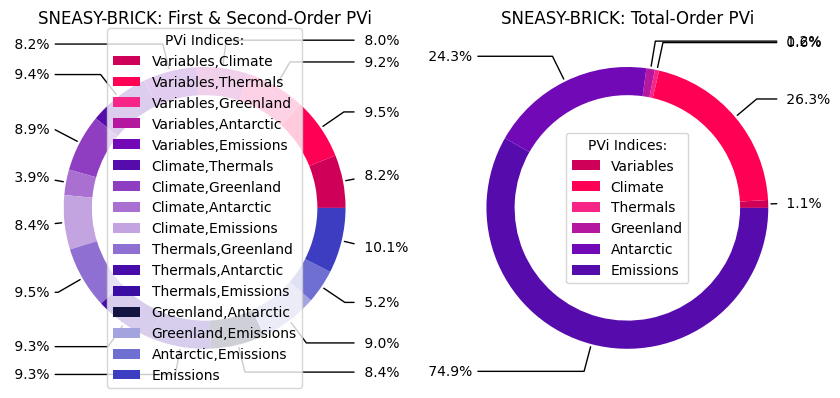

In [53]:
donut_chart(values, values1, labels, labels1, props, kw)

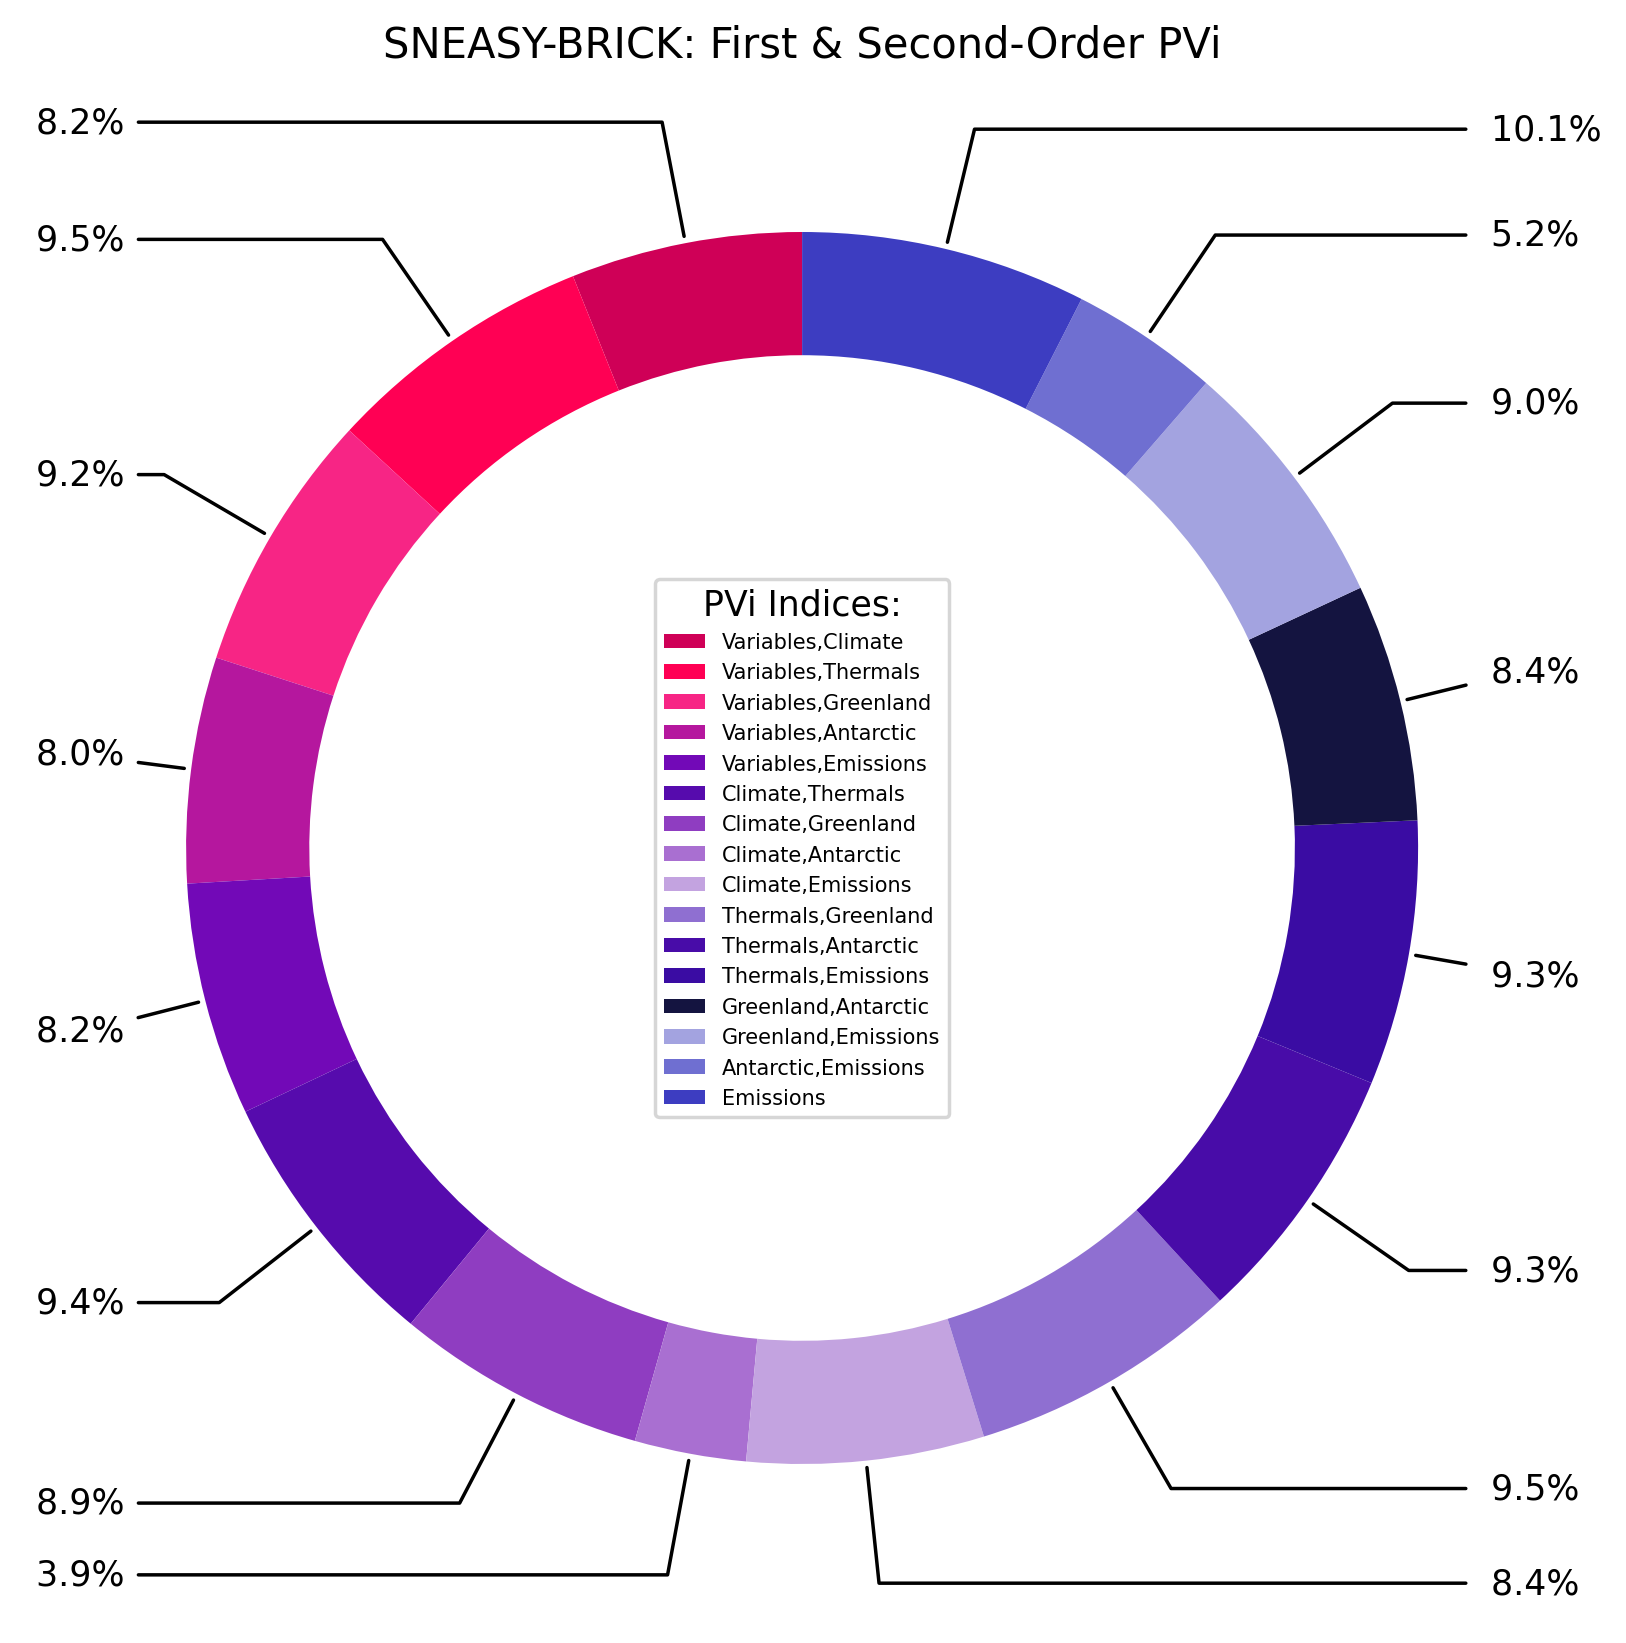

In [60]:
fig, ax= plt.subplots(1,1,dpi=250, figsize=(8,8))
wedges0, text0 = ax.pie(values,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
for i, p in enumerate(wedges0):
    ang = (p.theta2-p.theta1)/2 + p.theta1
    x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
    horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
    connectionstyle = f'angle, angleA=0, angleB={ang}'
    kw['arrowprops'].update({'connectionstyle':connectionstyle})
    ax.annotate(f'{values[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
ax.set_title('SNEASY-BRICK: First & Second-Order PVi')
ax.legend(labels=labels,loc='center', title='PVi Indices:' , prop={'size':6})
plt.show()

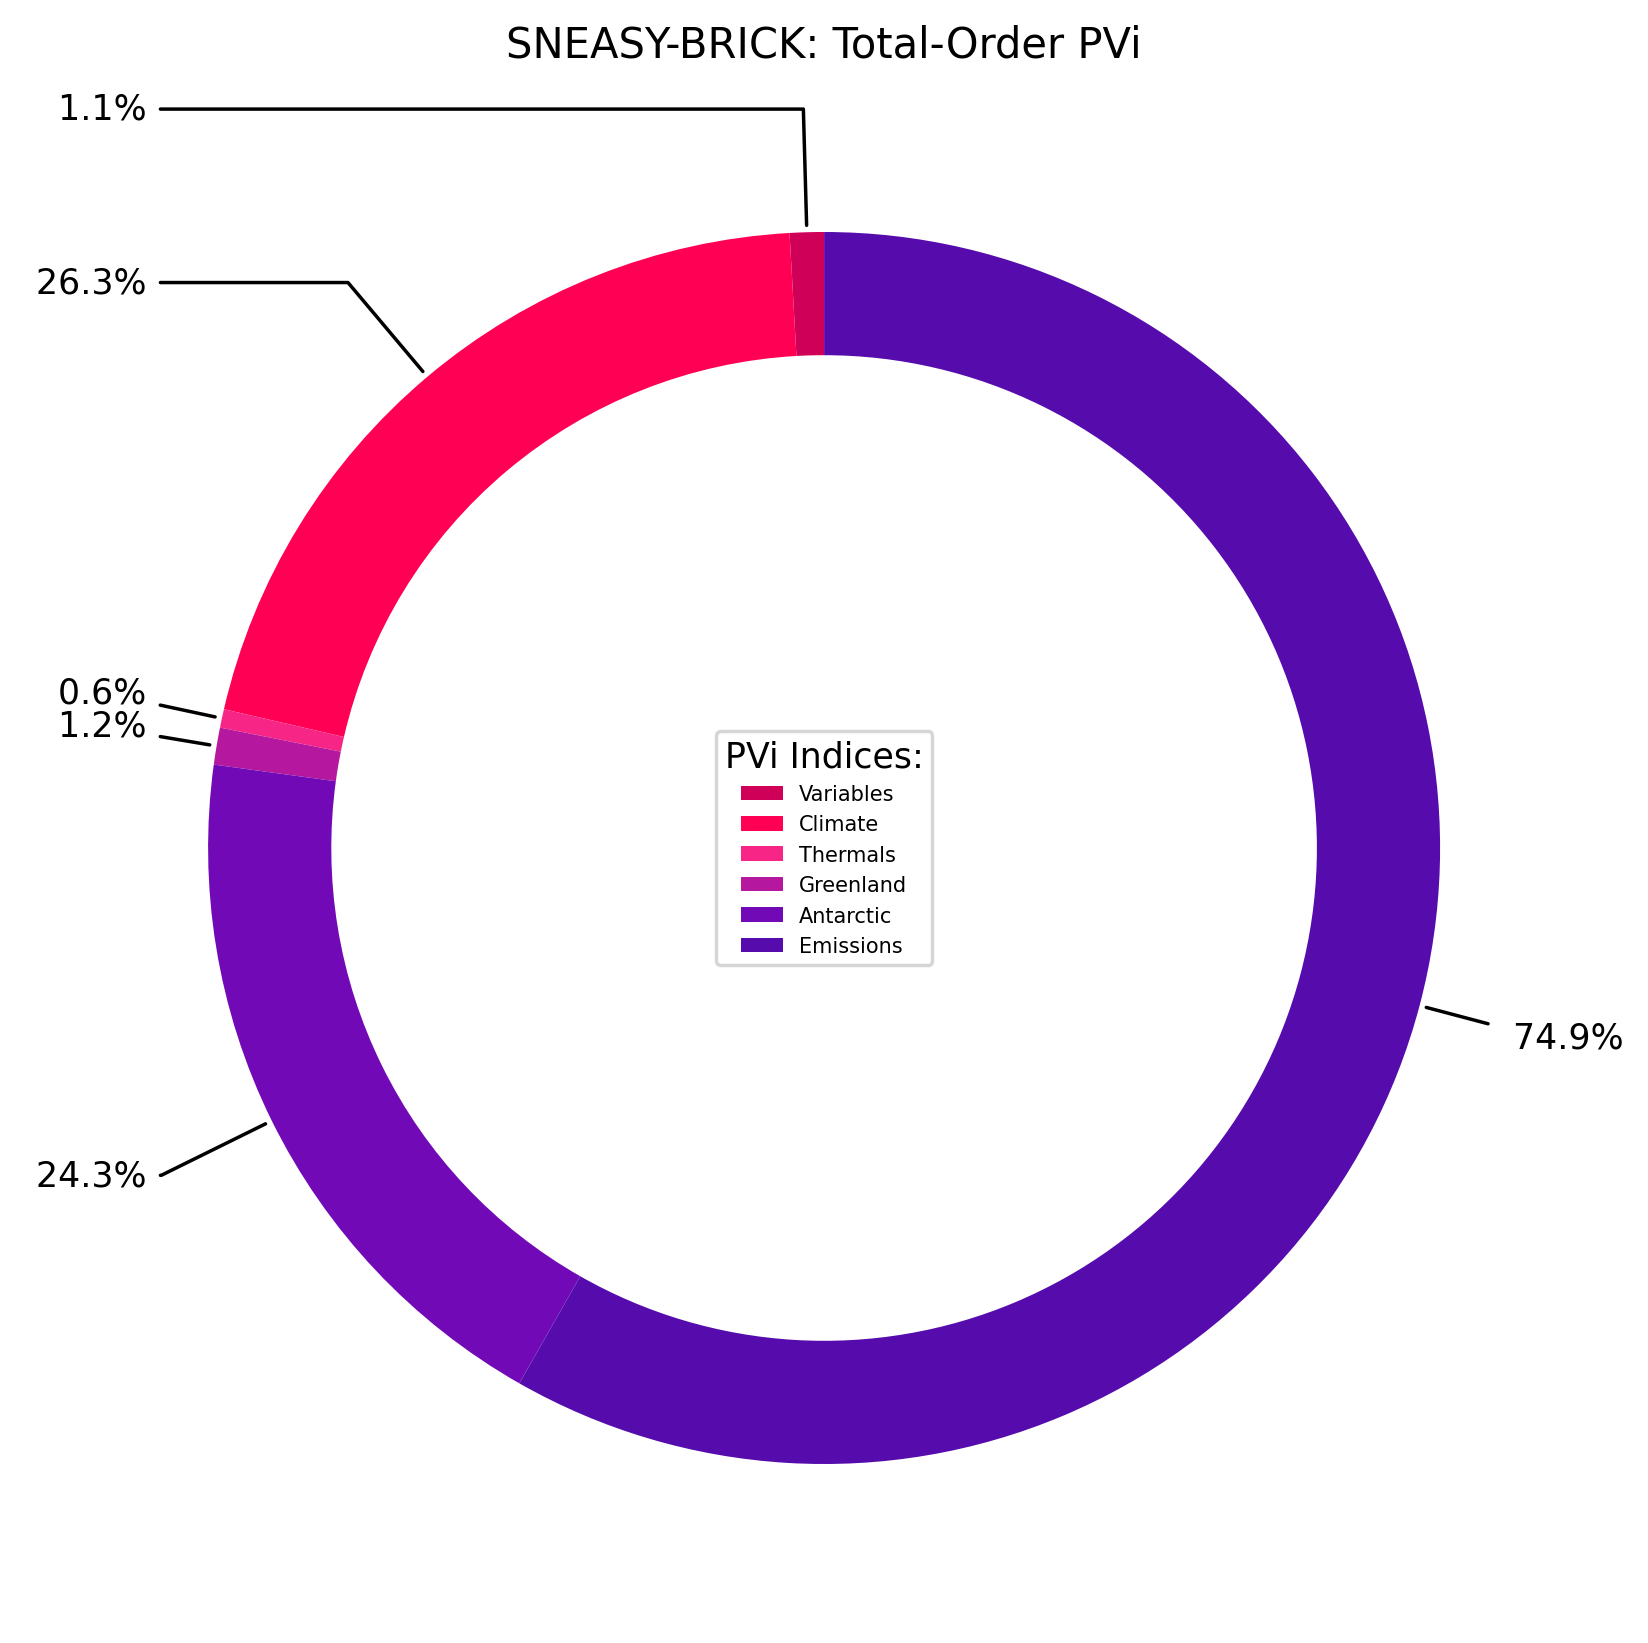

In [62]:
fig, ax= plt.subplots(1,1,dpi=250, figsize=(8,8))
wedges0, text0 = ax.pie(values1,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
for i, p in enumerate(wedges0):
    ang = (p.theta2-p.theta1)/2 + p.theta1
    x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
    horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
    connectionstyle = f'angle, angleA=0, angleB={ang}'
    kw['arrowprops'].update({'connectionstyle':connectionstyle})
    ax.annotate(f'{values1[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
ax.set_title('SNEASY-BRICK: Total-Order PVi')
ax.legend(labels=labels1,loc='center', title='PVi Indices:' , prop={'size':6})
plt.show()

In [29]:
PI_CI = PI.join(CI, how='left')
print(PI_CI.to_latex(float_format='{:.4f}'.format))

\begin{tabular}{lrrrr}
\toprule
 & $P_{i}$ & 5th & 95th & Quantile Difference \\
\midrule
Variables & -0.0792 & -0.0865 & -0.0718 & 0.0147 \\
Climate & -0.0618 & -0.0688 & -0.0542 & 0.0146 \\
Thermals & -0.0932 & -0.1004 & -0.0858 & 0.0146 \\
Greenland & -0.0854 & -0.0929 & -0.0779 & 0.0150 \\
Antarctic & -0.0406 & -0.0475 & -0.0340 & 0.0135 \\
Emissions & 0.1008 & 0.0942 & 0.1080 & 0.0139 \\
\bottomrule
\end{tabular}



In [30]:
PT = pd.DataFrame(PT.values(), index=PT.keys(), columns=[r'$P_{\tau}$'])

In [31]:
PT_CT = PT.join(CT, how='left')
print(PT_CT.to_latex(float_format='{:.4f}'.format))

\begin{tabular}{lrrrr}
\toprule
 & $P_{\tau}$ & 5th & 95th & Quantile Difference \\
\midrule
Variables & 0.0115 & 0.0113 & 0.0116 & 0.0003 \\
Climate & 0.2634 & 0.2605 & 0.2663 & 0.0059 \\
Thermals & 0.0062 & 0.0062 & 0.0063 & 0.0002 \\
Greenland & 0.0125 & 0.0123 & 0.0126 & 0.0003 \\
Antarctic & 0.2433 & 0.2408 & 0.2459 & 0.0051 \\
Emissions & 0.7487 & 0.7436 & 0.7535 & 0.0099 \\
\bottomrule
\end{tabular}



In [32]:
PIK_CIK = PIK.join(CIK, how='left')
print(PIK_CIK.to_latex(float_format='{:.4f}'.format))

\begin{tabular}{llrrrr}
\toprule
 &  & $P_{ik}$ & 5th & 95th & Quantile Difference \\
\midrule
\multirow[t]{5}{*}{Variables} & Climate & 0.0816 & 0.0739 & 0.0888 & 0.0148 \\
 & Thermals & 0.0952 & 0.0877 & 0.1028 & 0.0151 \\
 & Greenland & 0.0922 & 0.0847 & 0.0991 & 0.0144 \\
 & Antarctic & 0.0796 & 0.0729 & 0.0867 & 0.0138 \\
 & Emissions & 0.0823 & 0.0751 & 0.0892 & 0.0141 \\
\cline{1-6}
\multirow[t]{4}{*}{Climate} & Thermals & 0.0942 & 0.0874 & 0.1010 & 0.0136 \\
 & Greenland & 0.0885 & 0.0816 & 0.0958 & 0.0142 \\
 & Antarctic & 0.0394 & 0.0323 & 0.0466 & 0.0143 \\
 & Emissions & 0.0836 & 0.0766 & 0.0905 & 0.0139 \\
\cline{1-6}
\multirow[t]{3}{*}{Thermals} & Greenland & 0.0954 & 0.0880 & 0.1032 & 0.0152 \\
 & Antarctic & 0.0928 & 0.0860 & 0.1002 & 0.0142 \\
 & Emissions & 0.0934 & 0.0863 & 0.1005 & 0.0142 \\
\cline{1-6}
\multirow[t]{2}{*}{Greenland} & Antarctic & 0.0837 & 0.0764 & 0.0906 & 0.0142 \\
 & Emissions & 0.0897 & 0.0827 & 0.0970 & 0.0143 \\
\cline{1-6}
Antarctic & Emission

## RF Per Year Category

In [20]:
u_years = obj['t_peak'].unique() # Obtain the unique years
mask = u_years<2100

In [15]:
time_PI = dict()
time_PIK = dict()
time_PT = dict()
for year in u_years[mask]:
    # if year>=2161:
    #     pass
    # else:
    #     # print(year)
    mask = obj['t_peak'] < year
    val1 = train_test_split(obj[mask].iloc[:,:-1], obj[mask].iloc[:,-1], train_size=0.5, random_state=0, shuffle=False)
    RF = RandomForestRegressor(n_jobs=10, random_state=0)
    RF.fit(val1[0], val1[2])
    time_PI[year] = mod_pvi1(val1[0], val1[2], RF.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
    time_PT[year] = mod_pvi_t(val1[0], val1[2], RF.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
    time_PIK[year] = mod_pvi2(val1[0], val1[2], RF.predict,S_I=time_PI[year], n_boots=1000, alpha=0.05, columns_set=npv_column_set)

In [19]:
res = pd.DataFrame(time_PT.values(), index=time_PT.keys())
res.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Time_PVI\tot_time_PVI.xlsx")
res = pd.DataFrame(time_PI.values(), index=time_PI.keys())
res.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Time_PVI\first_time_PVI.xlsx")


# Feature Selection

We will append a noise feature $S_{\mathrm{var}}\sim \mathcal{N}(\mathbf{\overline{0}}, \sigma^{2})$  to the dataset, to accentuate pertinent features. Thereafter, we select features based upon the total-order PVi contribution of $S_{\mathrm{var}}$, as all features contributing $\leqslant$ are equally insignificant.

In [25]:
# Redefing the TPVi for compatibility
def mpt(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,n_boots: int, alpha: float, column_set: list[str]) -> np.ndarray[float]:
    '''
    ===Total-Order Permutation Variable Importances===

        data: your training dataset
        y_pred: your model output (specifically the prediction of your 'data' arg)
        f: in this case, simply RF.predict
    '''
    rows, columns = data.shape
    npv_columns = column_set
    u = dict()
    V_y = np.var(y_true,ddof=1 )
    CI = dict()
    for col in npv_columns:
        d = data.copy()
        d[col] = np.roll(data[col],rows//2, axis=0)
        y_pred = f(d)
        u[col] = np.mean(np.square(y_true - y_pred))/(2*V_y)
        S_CI = bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
        p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
        CI[col] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'
    S_t = pd.DataFrame(u.values(), index=u.keys(), columns=[r'$P_{\tau}$'])
    return u, CI

In [26]:
X = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\parameters.csv")
# X.drop(columns=list(feat_tb_dropped), inplace=True)
Y = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\gmslr.csv")
Y = Y.mean(axis=1).rename('output')
obj = X.join(Y, how='left')
S_var = np.random.standard_normal(size=obj.shape[0])
obj.insert(0, 'S_var',S_var)
obj.sort_values(by='t_peak',ascending=True, inplace=True)

In [27]:
obj

,S_var,gamma_g,t_peak,gamma_d,sd_temp,sd_ocean_heat,sd_glaciers,sd_greenland,sd_antarctic,sd_gmsl,...,antarctic_kappa,antarctic_flow0,antarctic_runoff_height0,antarctic_c,antarctic_bed_height0,antarctic_slope,antarctic_lambda,antarctic_temp_threshold,lw_random_sample,output
75300,-0.474647,0.006347,2030.0,0.063484,0.085504,1.531144,0.000034,0.000207,0.000130,0.001524,...,0.037543,1.525722,1788.008184,102.503463,741.445846,0.000646,0.008453,-15.477981,0.000482,0.698388
10964,1.058180,0.007240,2030.0,0.040575,0.085529,1.438011,0.000016,0.000282,0.000330,0.001650,...,0.064268,1.227204,1483.309624,140.186655,778.177732,0.000704,0.009543,-15.788140,0.000020,0.331414
70160,0.453333,0.002259,2030.0,0.144216,0.092857,3.723968,0.000323,0.000209,0.000514,0.001650,...,0.033567,1.660323,1520.205881,88.304474,809.067960,0.000643,0.017545,-16.382468,0.000483,0.413392
55254,0.346553,0.011053,2030.0,0.122078,0.079322,3.501653,0.000098,0.000281,0.000548,0.000294,...,0.065723,1.606463,2000.054921,138.560673,740.928017,0.000657,0.022982,-16.102901,0.000169,0.425493
92866,-0.999285,0.011820,2030.0,0.107974,0.084704,0.286660,0.000283,0.000252,0.000342,0.001516,...,0.080096,0.979125,972.389176,120.286640,814.950370,0.000725,0.006661,-15.362369,0.000193,0.352666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52429,-0.779009,0.013229,2167.0,0.093814,0.080127,1.034033,0.000253,0.000202,0.000538,0.000763,...,0.069314,1.460019,1379.251183,117.385686,797.296496,0.000668,0.011739,-16.190533,0.000739,3.135588
26215,0.398656,0.003130,2169.0,0.022636,0.079961,2.088501,0.000069,0.000217,0.000380,0.001736,...,0.065737,1.516385,1673.690577,136.186139,787.740252,0.000562,0.012827,-16.224729,0.000183,2.118476
87383,1.097738,0.004158,2171.0,0.120120,0.078078,0.375789,0.000049,0.000264,0.000451,0.002437,...,0.080312,0.812621,1340.939748,76.307069,798.575153,0.000548,0.009879,-15.795974,0.000354,2.240000
43691,1.704486,0.007347,2172.0,0.049480,0.072067,2.871035,0.000278,0.000222,0.000539,0.001515,...,0.078433,1.567668,1431.133514,120.324753,811.646750,0.000652,0.014322,-15.887230,0.000333,2.066674


In [31]:
# Model Fitting
val1 = train_test_split(obj.iloc[:,:-1],obj.iloc[:,-1], shuffle=False, train_size=0.8,random_state=0)
RF1 = RandomForestRegressor(n_estimators=300,n_jobs=24, random_state=0)
RF1.fit(val1[0],val1[2])
RF1.feature_importances_

array([0.00239353, 0.04106152, 0.29862701, 0.15857726, 0.0016312 ,
       0.00161601, 0.00166536, 0.00177671, 0.00197491, 0.00175409,
       0.00165221, 0.00158063, 0.00159394, 0.0022727 , 0.00167079,
       0.0022267 , 0.00163945, 0.00163014, 0.00221331, 0.00206368,
       0.00163439, 0.00173148, 0.00169434, 0.00162323, 0.00156183,
       0.00546744, 0.00172742, 0.00215805, 0.00179873, 0.00836462,
       0.18414311, 0.00216881, 0.00319133, 0.00407547, 0.00217625,
       0.00472376, 0.0014952 , 0.0016494 , 0.00194084, 0.00157068,
       0.0016094 , 0.0016551 , 0.00608675, 0.0017068 , 0.00246549,
       0.00176837, 0.00189633, 0.00202423, 0.00173805, 0.00158296,
       0.00154659, 0.08724233, 0.1211544 , 0.00300563])

In [35]:
def mpv1(data: pd.DataFrame, y_true: np.ndarray[float], f: callable,*, n_boots: int, alpha: float, column_set: dict) -> tuple[pd.DataFrame]:
    rows, columns = data.shape
    npv_columns = column_set
    V_y = np.var(y_true, ddof=1)
    u = dict()
    CI = dict()
    rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    # rolled_data = np.roll(data.copy(), rows//2, axis=0)
    for col in npv_columns:
        d = rolled_data.copy()
        d[col] = data[col].to_numpy()
        y_pred = f(d)
        u[col] = 1-np.mean(np.square(y_true - y_pred))/(2*V_y)
        S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
        p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
        CI[col] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'
    SI = pd.DataFrame(u.values(), index=u.keys(), columns=['$P_{i}$'])
    return u,CI

In [36]:
def mpv2(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,S_I: np.ndarray[float] ,n_boots: int, alpha: float, columns_set: dict) -> tuple[np.ndarray[float], list]:
    '''
    ===Second-Order Permutation Variable Importances (Full Matrix)===

        data: your training dataset
        y_pred: your model output (specifically the y_true value)
        f: in this case, simply RF.predict

        S_I: First-Order Importances
        n_boots: number of bootstrap samples
        alpha: parameter for confidence interval [alpha, 1-alpha]
        S_CI: sampling distribution 
        CI: Confidence Intervals
    '''
    rows, columns = data.shape
    npv_columns = columns_set
    n = n_boots
    S = dict()
    CI = dict()
    V_y = np.var(y_true, ddof=1)
    rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    # rolled_data = np.roll(data.copy(), rows//2, axis=0)
    for col1, col2 in it.combinations(npv_columns, r=2):
        d = rolled_data.copy()
        d[[col1,col2]] = data[[col1,col2]].to_numpy()
        y_pred = f(d)
        S_cat1 = S_I[col1]
        S_cat2 = S_I[col2]
        S[(col1, col2)] = 1 - np.mean(np.square(y_true - y_pred))/(2*V_y) - S_cat1 - S_cat2
        S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y) - S_cat1 - S_cat2 # Bootstrap Process
        p0,p1= np.quantile(S_CI, [alpha,1-alpha])
        CI[(col1, col2)] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'

    # S = pd.DataFrame(S.values(), index=S.keys(), columns=[r'$P_{ik}$'])
    return S, CI

In [37]:
PI, CI = mpv1(val1[0], val1[2], RF1.predict, n_boots=1000, alpha=0.05, column_set=val1[0].columns)
PI = pd.DataFrame(PI.values(), index=PI.keys())
np.set_printoptions(threshold=10_000)
print(PI)
print(CI)

                                 0
S_var                    -0.095875
gamma_g                  -0.062365
t_peak                    0.371545
gamma_d                   0.060863
sd_temp                  -0.096056
sd_ocean_heat            -0.096096
sd_glaciers              -0.096107
sd_greenland             -0.095703
sd_antarctic             -0.095549
sd_gmsl                  -0.095957
rho_temperature          -0.096033
rho_ocean_heat           -0.096135
rho_glaciers             -0.096133
rho_greenland            -0.094558
rho_antarctic            -0.096074
rho_gmsl                 -0.095048
CO2_0                    -0.096098
N2O_0                    -0.096029
temperature_0            -0.093447
ocean_heat_0             -0.094468
thermal_s0               -0.096089
greenland_v0             -0.096056
glaciers_v0              -0.096064
glaciers_s0              -0.096076
antarctic_s0             -0.096152
Q10                      -0.092059
CO2_fertilization        -0.095993
CO2_diffusivity     

In [38]:
PIK, CIK = mpv2(val1[0], val1[2], RF1.predict,S_I=PI.to_dict()[0], n_boots=1000, alpha=0.05, columns_set=val1[0].columns)
PIK = pd.DataFrame(PIK.values(), index=PIK.keys())
PIK

0
S_var                    gamma_g                   0.096755
                         t_peak                    0.095877
                         gamma_d                   0.096479
                         sd_temp                   0.097409
                         sd_ocean_heat             0.097403
...                                                     ...
antarctic_slope          antarctic_temp_threshold  0.096519
                         lw_random_sample          0.097388
antarctic_lambda         antarctic_temp_threshold  0.085327
                         lw_random_sample          0.096314
antarctic_temp_threshold lw_random_sample          0.095901

[1431 rows x 1 columns]

In [39]:
PIK.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\PVi_model_measures\Second_Order_PVI.xlsx")

In [43]:
PIK[PIK<PIK.loc['S_var'].mean()]

0
S_var                    gamma_g                   0.096755
                         t_peak                    0.095877
                         gamma_d                   0.096479
                         sd_temp                        NaN
                         sd_ocean_heat                  NaN
...                                                     ...
antarctic_slope          antarctic_temp_threshold  0.096519
                         lw_random_sample               NaN
antarctic_lambda         antarctic_temp_threshold  0.085327
                         lw_random_sample          0.096314
antarctic_temp_threshold lw_random_sample          0.095901

[1431 rows x 1 columns]

In [62]:
innerik = PIK.to_dict()[0]
innerik

{('S_var', 'gamma_g'): 0.07401125440009904,
 ('S_var', 't_peak'): 0.08751825096841126,
 ('S_var', 'gamma_d'): 0.0686233882343148,
 ('S_var', 'sd_temp'): 0.09689680658224331,
 ('S_var', 'sd_ocean_heat'): 0.09697420534488199,
 ('S_var', 'sd_glaciers'): 0.0969180495826113,
 ('S_var', 'sd_greenland'): 0.09681401534680412,
 ('S_var', 'sd_antarctic'): 0.0965035269116673,
 ('S_var', 'sd_gmsl'): 0.09686812923144383,
 ('S_var', 'rho_temperature'): 0.096948249157909,
 ('S_var', 'rho_ocean_heat'): 0.09694435450081385,
 ('S_var', 'rho_glaciers'): 0.09689371765840116,
 ('S_var', 'rho_greenland'): 0.09649956175978902,
 ('S_var', 'rho_antarctic'): 0.09691735328661422,
 ('S_var', 'rho_gmsl'): 0.09641844658685128,
 ('S_var', 'CO2_0'): 0.09692880623073874,
 ('S_var', 'N2O_0'): 0.09698738625448089,
 ('S_var', 'temperature_0'): 0.09647991649216836,
 ('S_var', 'ocean_heat_0'): 0.09666580395540414,
 ('S_var', 'thermal_s0'): 0.09699507552863862,
 ('S_var', 'greenland_v0'): 0.09682936119938701,
 ('S_var', 'gl

In [63]:
PIK_S_var = {key: innerik[key] for key in innerik.keys() if 'S_var' in key}

In [78]:
avg_svar = np.mean(list(PIK_S_var.values()))
std_svar = np.std(list(PIK_S_var.values())) # Average S_var interaction

In [81]:
avg_svar - std_svar

np.float64(0.08831808626148197)

In [90]:
PIK_Svar_complement = innerik.keys()-PIK_S_var.keys()
ps_comp_values = {key: innerik[key] for key in PIK_Svar_complement}
li = [[key, ps_comp_values[key]]for key in ps_comp_values.keys() if ps_comp_values[key]>avg_svar]
si = {key: ps_comp_values[key] for key in ps_comp_values.keys() if ps_comp_values[key]>avg_svar}

In [94]:
removed_feat = (ps_comp_values.keys() - si.keys())
np.unique(np.array([[tup1, tup2] for tup1, tup2 in removed_feat]).flatten())

array(['Q10', 'antarctic_lambda', 'antarctic_mu',
       'antarctic_temp_threshold', 'climate_sensitivity', 'gamma_d',
       'gamma_g', 'rf_scale_aerosol', 'temperature_0'], dtype='<U24')

In [ ]:
print(len(list(filter(lambda x: x>np.asarray(PIK_S_var).any(), PIK.values()))))

In [95]:
PT, CT = mpt(val1[0], val1[2], RF1.predict, n_boots=1000, alpha=0.05, column_set=val1[0].columns)

In [96]:
PT = pd.Series(PT.values(), index=PT.keys())

In [97]:
# Features <= the importance of S_var
feat_tb_dropped = PT[PT<=PT.loc['S_var']].dropna()

In [98]:
feat_tb_dropped = set(feat_tb_dropped.index) - {'S_var'}

In [99]:
feat_tb_dropped

{'CO2_0',
 'CO2_diffusivity',
 'CO2_fertilization',
 'N2O_0',
 'Q10',
 'antarctic_alpha',
 'antarctic_bed_height0',
 'antarctic_c',
 'antarctic_flow0',
 'antarctic_gamma',
 'antarctic_kappa',
 'antarctic_lambda',
 'antarctic_mu',
 'antarctic_nu',
 'antarctic_precip0',
 'antarctic_runoff_height0',
 'antarctic_s0',
 'antarctic_slope',
 'antarctic_temp_threshold',
 'anto_alpha',
 'anto_beta',
 'climate_sensitivity',
 'gamma_d',
 'gamma_g',
 'glaciers_beta0',
 'glaciers_n',
 'glaciers_s0',
 'glaciers_v0',
 'greenland_a',
 'greenland_alpha',
 'greenland_b',
 'greenland_beta',
 'greenland_v0',
 'heat_diffusivity',
 'lw_random_sample',
 'ocean_heat_0',
 'rf_scale_aerosol',
 'rho_antarctic',
 'rho_glaciers',
 'rho_gmsl',
 'rho_greenland',
 'rho_ocean_heat',
 'rho_temperature',
 'sd_antarctic',
 'sd_glaciers',
 'sd_gmsl',
 'sd_greenland',
 'sd_ocean_heat',
 'sd_temp',
 't_peak',
 'temperature_0',
 'thermal_alpha',
 'thermal_s0'}

Now that I've found the features contributing little to the predicition of the model output, we can remove them and re-train, validate, and test our the new RF model.

**Reloading the dataset**

In [52]:
X = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\parameters.csv")
X.drop(columns=list(feat_tb_dropped), inplace=True)
Y = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\gmslr.csv")
Y = Y.mean(axis=1).rename('output')
obj = X.join(Y, how='left')
obj.sort_values(by='t_peak',ascending=True, inplace=True)

In [ ]:
obj

**Model Validation/Calibration No.1**\
As this is a time-series dataset, we define a new variable ```val2``` that partitions the dataset (w/o shuffling) into train/validation. When it's time to 'test' the performance of the model, we will switch to ```train_test_split```.

In [54]:
# val2 = train_test_split(obj.iloc[:,:-1],obj.iloc[:,-1],shuffle=False, train_size=0.8, random_state=0)
val2 = TimeSeriesSplit(n_splits=4, max_train_size=60_000)
RF = RandomForestRegressor(random_state=0)

**Model Validation/Calibration No.2**\
Defining the parameter space.

In [55]:

parameter_space = dict()
parameter_space['n_estimators'] = Integer(30,400)
# parameter_space['min_samples_split'] = Integer(2,5, prior='uniform')
# parameter_space['min_samples_leaf'] = Integer(1,5)
parameter_space['max_features'] = Integer(10,53)
parameter_space['max_depth'] = Integer(10,80)
# parameter_space['ccp_alpha'] = Real(1e-4, 5e-4)

In [ ]:
bae = BayesSearchCV(estimator=RF,search_spaces=parameter_space,verbose=2, n_iter=100, scoring='neg_mean_squared_error', n_points=6, cv=val2, n_jobs=24, random_state=0)
bae.fit(obj.iloc[:,:-1], obj.iloc[:,-1])
res = pd.DataFrame(bae.cv_results_)
res.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Hyperparameter_Tuning\Darnell_HT_MSE_SF_1.xlsx")
res.to_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Hyperparameter_Tuning\Darnell_HT_MSE_SF_1.csv")
print(f'Best Parameters:{bae.best_params_} with MSE: {bae.best_score_}')

In [ ]:
val2 = train_test_split(obj.iloc[:,:-1],obj.iloc[:,-1],shuffle=False, train_size=0.8, random_state=0)
RF1 = RandomForestRegressor(n_estimators=400, max_features=21, max_depth=31, n_jobs=20, random_state=0)
RF1.fit(val2[0], val2[2])

In [ ]:
val2[0]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=150)

plt.plot(val2[1].t_peak, val2[3], color='blue', label='True')
plt.plot(val2[1].t_peak, RF1.predict(val2[1]), color='firebrick', label='Predicted')
plt.title('Test Predictions vs. True Output')
plt.legend()

In [65]:
PI, CI = mpv1(val2[0], val2[2], RF1.predict, n_boots=1000, alpha=0.05, column_set=val2[0].columns)
PIK, CIK = mpv2(val2[0], val2[2], RF1.predict,S_I=PI, n_boots=1000, alpha=0.05, columns_set=val2[0].columns)

In [ ]:
pd.set_option('display.max_rows', 10000)
PIK = pd.DataFrame(PIK.values(),index=PIK.keys())
PIK

In [72]:
pd.set_option('display.max_rows', 10000)

In [ ]:
PIK

In [ ]:
CIK